## Imports & Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip, Grayscale, Normalize
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from helpers import *

In [2]:
torch.manual_seed(168)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prepare Dataset

In [4]:
size = 64
batch_size = 64
transformation = Compose([RandomHorizontalFlip(), Resize((size, size)), ToTensor()])

In [5]:
root = 'real_easy_and_mid/train'
train_data1 = create_dataset(root, transformation)
train_loader1 = produce_loader(train_data1, batch_size)

In [6]:
root = 'real_easy_and_mid/test'
test_data1 = create_dataset(root, transformation)
test_loader1 = produce_loader(test_data1, 1)

In [7]:
root = 'real_easy_and_mid/val'
val_data1 = create_dataset(root, transformation)
val_loader1 = produce_loader(val_data1, batch_size)

[678, 1173, 110, 819, 1022, 503, 409, 570, 130]


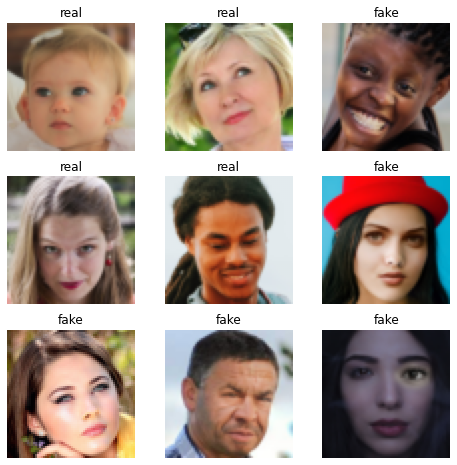

In [8]:
visualize_data(train_data1)

[74, 114, 24, 124, 147, 31, 14, 28, 109]


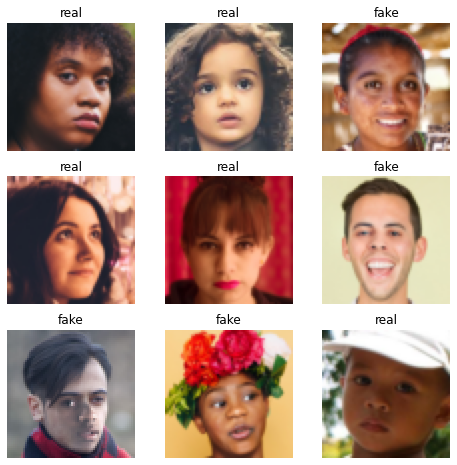

In [9]:
visualize_data(test_data1)

In [10]:
root = 'real_and_hard/train'
train_data2 = create_dataset(root, transformation)
train_loader2 = produce_loader(train_data2, batch_size)

In [11]:
root = 'real_and_hard/test'
test_data2 = create_dataset(root, transformation)
test_loader2 = produce_loader(test_data2, 1)

In [12]:
root = 'real_and_hard/val'
val_data2 = create_dataset(root, transformation)
val_loader2 = produce_loader(val_data2, batch_size)

[403, 52, 120, 357, 88, 109, 87, 367, 364]


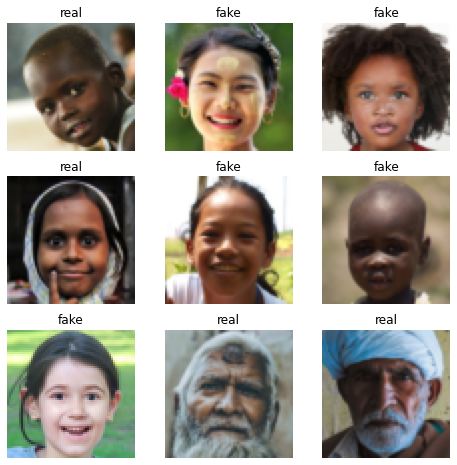

In [13]:
visualize_data(train_data2)

[19, 16, 18, 33, 20, 29, 44, 24, 3]


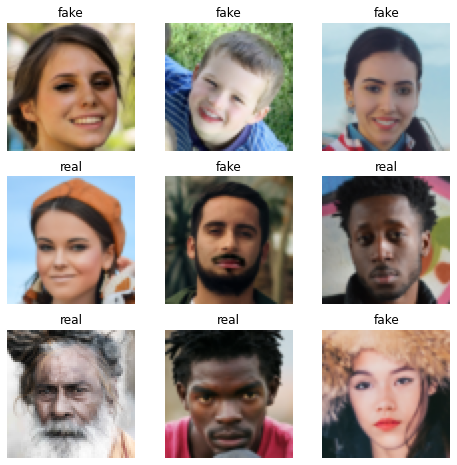

In [14]:
visualize_data(test_data2)

## Model Definition

In [15]:
class DeepLearnConv(torch.nn.Module):
    def __init__(self, inputs, outputs, weights, kernel_size):
        super(DeepLearnConv, self).__init__()
        
        self.conv = nn.Conv2d(inputs, outputs, kernel_size = kernel_size)
        with torch.no_grad():
            self.conv.weight = nn.Parameter(weights)
        self.batch_norm = nn.BatchNorm2d(outputs)
        self.dropout = nn.Dropout2d(0.5)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        return x

In [16]:
class DeepLearnLinear(torch.nn.Module):
    def __init__(self, inputs, outputs):
        super(DeepLearnLinear, self).__init__()
        
        self.linear = nn.Linear(inputs, outputs)
        nn.init.xavier_uniform_(self.linear.weight)
        self.batch_norm = nn.BatchNorm1d(outputs)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.linear(x)
        x = self.batch_norm(x)
        x = torch.relu(x)
        x = self.dropout(x)
        return x

In [17]:
class DeepLearn(torch.nn.Module):
    def __init__(self, kernels, hidden, kernel_size, window, hidden_linear, labels):
        super(DeepLearn, self).__init__()
        
        self.kernels = kernels
        self.conv = [DeepLearnConv(hidden[i], hidden[i+1], 
                                    self.kernels[i].view(1, 1, 3, 3).repeat(hidden[i+1], hidden[i], 1, 1), 
                                    kernel_size) for i in range(len(hidden)-1)]
        self.conv_combined = nn.Sequential(*self.conv)
        
        self.maxpool = nn.MaxPool2d(window)
        self.flattened = hidden_linear[0]
        self.linear= [DeepLearnLinear(hidden_linear[i], hidden_linear[i+1]) for i in range(len(hidden_linear)-1)]
        self.linear_combined = nn.Sequential(*self.linear)
        
        self.output = nn.Linear(hidden_linear[-1], labels)
    
    def forward(self, x):
        x = self.conv_combined(x)
        x = self.maxpool(x)
        x = x.view(-1, self.flattened)
        x = self.linear_combined(x)
        x = self.output(x)
        return x

## Training Model & Hyperparameter Tuning

In [18]:
def create_adam_optimizer(lr = 0.1, betas=(0.9, 0.999), amsgrad=False):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

In [19]:
from math import floor
#sharp sobel kernels
kernels = [torch.tensor([[0., -1., 0.],
                        [-1., 5., -1.],
                        [0., -1., 0.]]),
           torch.tensor([[1., 2., 1.],
                        [0., 0., 0.],
                        [-1., -2., -1.]]),
           torch.tensor([[1., 0., -1.],
                        [2., 0., -2.],
                        [1., 0., -1.]])]

# number of hidden layers and their sizes
hidden = [3, 128, 64, 32]

# kernel size of convolution layers
kernel_size = 3

# window size of maxpooling layer
window = 3

# calculate final size of image
channels = hidden[-1]
changed_img = floor( (size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img

# final linear layers and their sizes
hidden_linear = [flattened, 1024, 128]
labels = 2

In [20]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [21]:
train_losses_hard = []
train_accuracies_hard = []
val_losses_hard = []
val_accuracies_hard = []

In [22]:
model = DeepLearn(kernels=kernels, hidden=hidden, kernel_size=kernel_size, window=window,
                   hidden_linear=hidden_linear, labels=labels).to(device)
optimizer = create_adam_optimizer(lr=0.01)
print(model)

DeepLearn(
  (conv_combined): Sequential(
    (0): DeepLearnConv(
      (conv): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (1): DeepLearnConv(
      (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (2): DeepLearnConv(
      (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (linear_combined): Sequential(
    (0): DeepLearnLinear(
      (linear): Linear(in_features=11552, out_features=1024, bias=True)
    

In [36]:
# repeat this cell with epochs = 1 for safety, but usually epochs = 3 is a good start
tl, ta, vl, va = train(device, model, train_loader1, val_loader1, epochs = 2, optimizer = optimizer)
train_losses+=tl
train_accuracies+=ta
val_losses+=vl
val_accuracies+=va

Epoch 1/2, Batch number: 0, Cumulated accuracy: 0.625
Epoch 1/2, Batch number: 5, Cumulated accuracy: 0.5755208333333334
Epoch 1/2, Batch number: 10, Cumulated accuracy: 0.5696022727272727
Epoch 1/2, Batch number: 15, Cumulated accuracy: 0.5712890625
--- Epoch 1/2: Train loss: 0.6940, Train accuracy: 0.5695
--- Epoch 1/2: Val loss: 0.7167, Val accuracy: 0.5267
Epoch 2/2, Batch number: 0, Cumulated accuracy: 0.484375
Epoch 2/2, Batch number: 5, Cumulated accuracy: 0.578125
Epoch 2/2, Batch number: 10, Cumulated accuracy: 0.5866477272727273
Epoch 2/2, Batch number: 15, Cumulated accuracy: 0.5830078125
--- Epoch 2/2: Train loss: 0.6913, Train accuracy: 0.5762
--- Epoch 2/2: Val loss: 0.6919, Val accuracy: 0.5867


In [37]:
# repeat this cell with epochs = 1 for safety, but usually epochs = 3 is a good start
tl, ta, vl, va = train(device, model, train_loader2, val_loader2, epochs = 1, optimizer = optimizer)
train_losses_hard+=tl
train_accuracies_hard+=ta
val_losses_hard+=vl
val_accuracies_hard+=va

Epoch 1/1, Batch number: 0, Cumulated accuracy: 0.65625
Epoch 1/1, Batch number: 5, Cumulated accuracy: 0.6067708333333334
--- Epoch 1/1: Train loss: 0.6915, Train accuracy: 0.5856
--- Epoch 1/1: Val loss: 0.6670, Val accuracy: 0.6667


## Testing Model & Performance Curves

In [38]:
print('Test scores for easy and medium difficulty images:')
true_labels1, model_preds1, correct_list1, wrong_list1, test_loss1, test_accuracy1 = test(device, model, test_loader1, get_predictions=True)
print('Test scores for hard difficulty images:')
true_labels2, model_preds2, correct_list2, wrong_list2, test_loss2, test_accuracy2 = test(device, model, test_loader2, get_predictions=True)

Test scores for easy and medium difficulty images:
Test loss: 0.6419, Test accuracy: 0.6800
Test scores for hard difficulty images:
Test loss: 0.6909, Test accuracy: 0.5741


## Performance on Easy & Medium Difficulty Images

Precision: 0.6470588235294118
Recall: 0.8461538461538461
F1 score: 0.7333333333333334


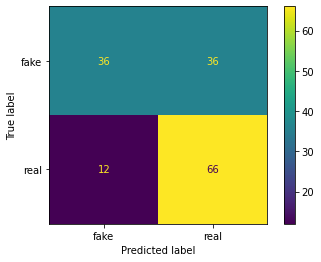

In [39]:
show_metrics(true_labels1, model_preds1)

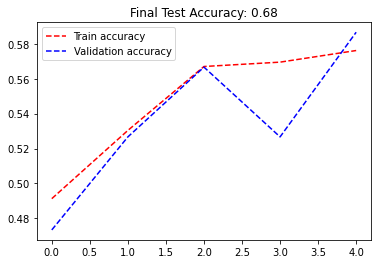

In [40]:
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
plt.title("Final Test Accuracy: {}".format(test_accuracy1))
plt.legend(loc='upper left')
plt.show()

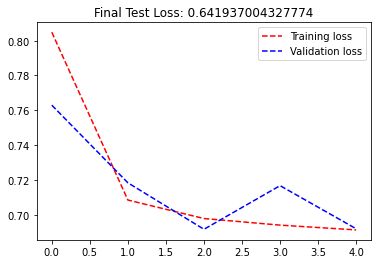

In [41]:
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
plt.title("Final Test Loss: {}".format(test_loss1))
plt.legend(loc='upper right')
plt.show()

[86, 23, 55, 75, 86, 49, 84, 56, 12]


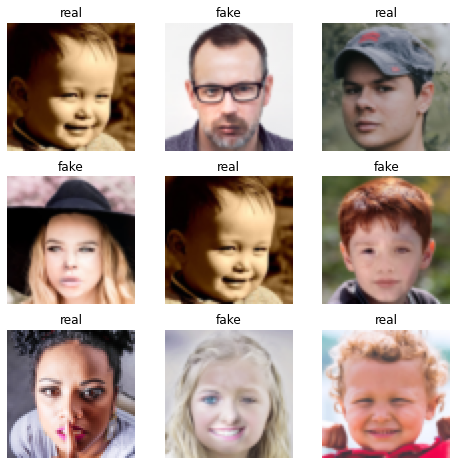

In [42]:
visualize_data(correct_list1)

[40, 31, 9, 19, 26, 18, 3, 19, 34]


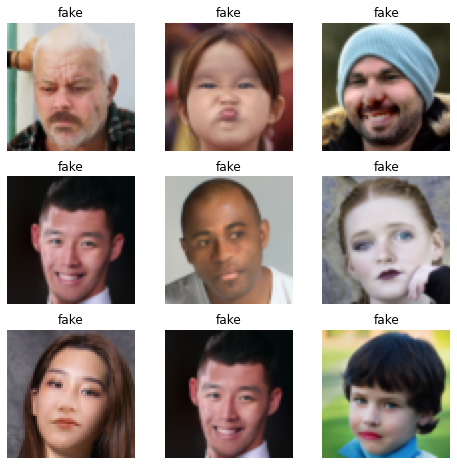

In [43]:
visualize_data(wrong_list1)

## Performance on Hard Difficulty Images

Precision: 0.6060606060606061
Recall: 0.6666666666666666
F1 score: 0.6349206349206349


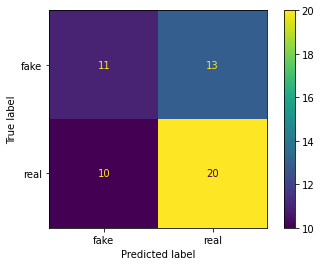

In [44]:
show_metrics(true_labels2, model_preds2)

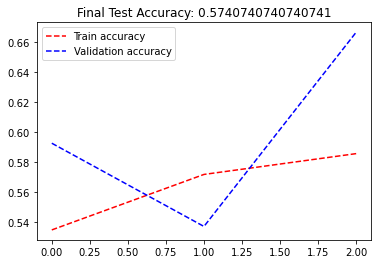

In [45]:
plt.plot(train_accuracies_hard, "r--", label='Train accuracy')
plt.plot(val_accuracies_hard, "b--", label='Validation accuracy')
plt.title("Final Test Accuracy: {}".format(test_accuracy2))
plt.legend(loc='upper left')
plt.show()

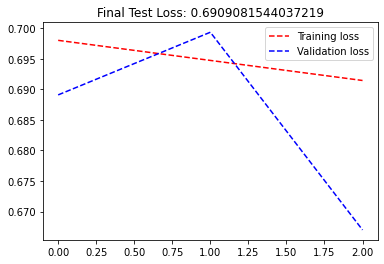

In [46]:
plt.plot(train_losses_hard, "r--", label='Training loss')
plt.plot(val_losses_hard, "b--", label='Validation loss')
plt.title("Final Test Loss: {}".format(test_loss2))
plt.legend(loc='upper right')
plt.show()

[5, 25, 6, 6, 24, 19, 18, 0, 10]


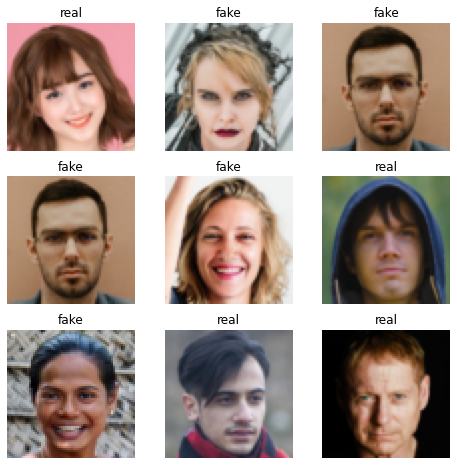

In [47]:
visualize_data(correct_list2)

[10, 12, 19, 16, 5, 22, 0, 14, 22]


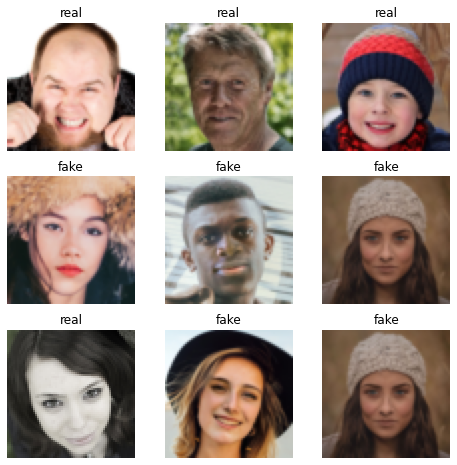

In [48]:
visualize_data(wrong_list2)

## Saving Model

torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, 
            './latest_16epochs')

model_test = DeepLearn(kernels=kernels, hidden=hidden, kernel_size=kernel_size, window=window,
                   hidden_linear=hidden_linear, labels=labels).to(device)
model_test.load_state_dict(torch.load("./latest_16epochs")["model_state_dict"])